# Simulating WFI Imaging Data with Roman I-Sim

***

## Nexus Server Information

**IMPORTANT: Running the parallelized examples in the advanced use cases section will require a "Medium" or larger server.**

## Kernel Information and Read-Only Status

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it.

## Reference Data

The cell below will check to ensure ancillary reference files for the `stpsf` package are installed. If not, it will download the ancillary reference files and install them under your home directory (i.e., `${HOME}/refdata/`).

### Local Run Settings

If you want to run the notebook in your local machine, refer to the information in the [local installation](../../../markdown/local-run.md) instructions before proceeding with the notebook. The instructions provide inportant information about setting up your environment, installing dependnecies, and adding to your working directory scripts to help with the reference data installation.

Depending on which (if any) reference data are missing, this cell may take several minutes to execute.

### On the Roman Research Nexus

If you are working on the Nexus, then the ancillary reference data are pre-installed and this cell will execute instantly.

In [1]:
import os
import sys
import importlib.util
import notebook_data_dependencies as ndd

# Download reference data (if necessary)
result = ndd.install_files(packages=['stpsf'])
ndd.setup_env(result)


Did not find stpsf data in environment, setting it up...
	Found 1 data URL(s) to download and install...
	Working on file 1 out of 1


	Update environment variable with the following:
		export STPSF_PATH='/home/runner/refdata/stpsf-data'
Reference data paths set to:
	STPSF_PATH = /home/runner/refdata/stpsf-data


## Imports
 Libraries used
- *argparse* for formatting input options in romanisim
- *asdf* for opening Roman WFI ASDF files
- *astroquery.gaia* for querying the Gaia catalog
- *astropy.coordinates* for storing celestial coordinates as Python objects
- *astropy.time* for storing time information as Python objects
- *astropy.table* for working with Astropy Table objects
- *astropy.units* for handling and combining units
- *astropy.visualization* for image normalization
- *copy* for making copies of Python objects
- *galsim* for image simulations
- *importlib* for reloading Python modules
- *matplotlib* for displaying images
- *numpy* for array operations
- *os* for file operations
- *romanisim* for image simulations
- *roman_datamodels* for opening Roman WFI ASDF files
- *s3fs* for accessing files in an S3 bucket

In the [Advanced Use Cases](#Advanced-Use-Cases) section further below, we include some additional imports:
- *pysiaf* for determining dither positions
- *dataclasses* for creating a class
- *typing* for doing type checking on inputs
- *dask* for parallelization

**Note:** `dask` is not installed in the Roman Calibration kernel by default. In the [Advanced Use Cases - Parallelized Simulations](#Parallelized-Simulations) section, the code cells have been commented out and there is a cell at the beginning of the section that will use `pip` to install the required packages.

In [2]:
import argparse
import asdf
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table, vstack
from astropy import units as u
from astropy.visualization import simple_norm
import copy
import galsim
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import roman_datamodels as rdm
from romanisim import gaia, bandpass, catalog, log, wcs, persistence, parameters, ris_make_utils as ris
from romanisim.image import inject_sources_into_l2
import s3fs

## Introduction

The purpose of this notebook is to show how to generate simulated Level 1 (L1; uncalibrated ramp cubes) and Level 2 (L2; calibrated rate images) Roman Wide Field Instrument (WFI) Advanced Scientific Data Format (ASDF) files with [Roman I-Sim](https://romanisim.readthedocs.io/en/latest/) (package name `romanisim`). Details about the Roman data levels can be found in the [Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products) article in the Roman Documentation System (RDox). Briefly, a L1 file contains a single uncalibrated ramp exposure in units of Data Numbers (DN).  L1 files are three-dimensional data cubes, one dimension for time and two dimensions for image coordinates, that are shaped as  arrays with (N resultants, 4096 image rows, 4096 image columns). A resultant is a sample up-the-ramp, and represents either a single read of the WFI detectors or multiple reads that have been combined. The L2 WFI data are calibrated images in instrumental units of DN / second.  They are two-dimensional arrays shaped as (4088 image rows, 4088 image columns).

***

## Tutorial Data

In this tutorial, we will create necessary data in memory or retrieve it from a catalog service. A catalog file is also available in the RRN S3 bucket, and can be streamed into memory using `astropy.table.Table` and the `s3fs` package instructions in the [Data Discovery and Access](../data_discovery_and_access/data_discovery_and_access.ipynb) tutorial. Also see the [RRN documentation](../../../markdown/simulated-data.md) for more information on the catalog available in the S3 bucket.

## Source Catalog Generation

The `romanisim` package offers two options for generating source catalogs:
1. Retrieve the source catalog from Gaia; or
2. Parametrically generate a catalog of stars and/or galaxies.

First, let's explore how to create a `romanisim`-compatible source catalog using Gaia. We will use a combination of `astroquery` and `romanisim` to query the Gaia catalog and then write the file in a format compatible with `romanisim`.

In the example below, we query the Gaia DR3 catalog for sources centered at (RA, Dec) = (270.94, -0.2) degrees within a radius of 1 degree.

**Note:** The Gaia query may take several minutes to complete.

In [3]:
ra = 270.94  # Right ascension in degrees
dec = -0.2  # Declination in degrees
radius = 1  # Search radius in degrees

query = f'SELECT * FROM gaiadr3.gaia_source WHERE distance({ra}, {dec}, ra, dec) < {radius}'
job = Gaia.launch_job_async(query)
print(job)
result = job.get_results()

2025-12-11 02:04:14 INFO     Query finished.


INFO: Query finished. [astroquery.utils.tap.core]
<Table length=389468>
              name               dtype       unit                                                                  description                                                              n_bad 
------------------------------- ------- ------------- ------------------------------------------------------------------------------------------------------------------------------------- ------
                    solution_id   int64                                                                                                                                 Solution Identifier      0
                    designation  object                                                                                         Unique source designation (unique across all Data Releases)      0
                      source_id   int64                                                                                  Unique source identifier (u

Once we have the result from the Gaia query, we can transform it into a format compatible with Roman I-Sim:

In [4]:
# Filter the Gaia results for stars and exclude bright stars
result = result[result['classprob_dsc_combmod_star'] >= 0.7]
result = result[result['phot_g_mean_mag'] > 16.5]

# Set the observation time
obs_time = '2026-10-31T00:00:00'

# Make the Roman I-Sim formatted catalog
gaia_catalog = gaia.gaia2romanisimcat(result, Time(obs_time), fluxfields=set(bandpass.galsim2roman_bandpass.values()))

We have excluded very bright stars (Gaia g-band > 16.5 mag in this example) because Roman I-Sim uses a maximum size of the simulated point spread function (PSF) in pixels that can result in the appearance of box-shaped boundaries around bright sources. This will be fixed in a future update.

When using a real catalog like Gaia, it is essential to remove any entries with missing information. This can be achieved with the code in the cell below:

In [5]:
# Reject anything with missing fluxes or positions
names = [f for f in gaia_catalog.dtype.names if f[0] == 'F']
names += ['ra', 'dec']

bad = np.zeros(len(gaia_catalog), dtype='bool')
for b in names:
      bad = ~np.isfinite(gaia_catalog[b])
      if hasattr(gaia_catalog[b], 'mask'):
           bad |= gaia_catalog[b].mask
      gaia_catalog = gaia_catalog[~bad]

Now that we have a catalog, let's take a look at it. The catalog in memory is an `astropy.table.Table` object with over 1e5 rows:

In [6]:
gaia_catalog

ra,dec,type,n,half_light_radius,pa,ba,F106,F087,F158,F184,F213,F062,F129,F146
float64,float64,str3,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
271.12256623811544,-1.1820752058916675,PSF,-1,-1,-1,-1,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08,3.079301038356309e-08
271.07624929979545,-1.1889119779773505,PSF,-1,-1,-1,-1,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08,1.2595514490200894e-08
271.07037703579505,-1.1868895976959661,PSF,-1,-1,-1,-1,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09,5.068913217772333e-09
271.1011360199251,-1.1819644933869804,PSF,-1,-1,-1,-1,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08,7.446602304507535e-08
271.1062876862371,-1.1849693586770516,PSF,-1,-1,-1,-1,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09,6.975707420198788e-09
271.09124019764727,-1.1720269613674617,PSF,-1,-1,-1,-1,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09,7.522956486137361e-09
271.0998422287016,-1.1702655154593578,PSF,-1,-1,-1,-1,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08,1.0216365392096818e-08
271.09585692456886,-1.1630299651780616,PSF,-1,-1,-1,-1,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07,1.3102949873437336e-07
271.1364640470983,-1.170440122775287,PSF,-1,-1,-1,-1,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08,1.1888697513236583e-08


Alternatively, we can generate a completely synthetic catalog of stars and galaxies using tools in Roman I-Sim (see parameters in the cell below). In this tutorial, we will simulate a galaxy catalog and merge it with the Gaia star catalog. This approach addresses the limitation of Gaia's catalog, which includes only relatively bright sources, by adding galaxies. At the same time, real Gaia point sources are necessary for the Roman calibration pipeline to match images to Gaia astrometry. 

Note that we can additionally simulate a star catalog if desired. This may be useful for including stars fainter than the Gaia magnitude limit, or when the Gaia astrometric step in RomanCal is not required.

Note that in the cell below, we have commented out the last line, which would save the catalog to disk as an Enhanced Character-Separated Values (ECSV) file. We do not need the catalog to be saved on disk for this tutorial, but you may optionally uncomment the line to save the file if you wish. The same file is available in the S3 bucket for any other tutorials that may need it. Having a saved version of the catalog removes the need to re-run the Gaia query above if you need to start over, but you will need to add code to read the catalog file below.

In [7]:
# Galaxy catalog parameters

ra = 270.94  # Right ascension of the catalog center in degrees
dec = -0.2  # Declination of the catalog center in degrees
radius = 1.0  # Radius of the catalog in degrees
n_gal = 30_000  # Number of galaxies
faint_mag = 22  # Faint magnitude limit of simulated sources
hlight_radius = 0.3  # Half-light radius at the faint magnitude limit in units of arcseconds
optical_element = 'F062 F087 F106 F129 F146 F158 F184 F213'.split()  # List of optical elements to simulate
seed = 4642  # Random number seed for reproducibility

# Create galaxy catalog
galaxy_cat = catalog.make_galaxies(SkyCoord(ra, dec, unit='deg'), n_gal, radius=radius, index=0.4, faintmag=faint_mag, 
                                   hlr_at_faintmag=hlight_radius, bandpasses=optical_element, rng=None, seed=seed)

# Merge the galaxy and Gaia catalogs
full_catalog = vstack([galaxy_cat, gaia_catalog])

#full_catalog.write('full_catalog.ecsv', format='ascii.ecsv', overwrite=True)

The following cell is commented out, but if uncommented will create a simulated star catalog.

In [8]:
#n_star = 30_000  # Number of stars

#star_cat = catalog.make_stars(SkyCoord(ra, dec, unit='deg'), n_star, radius=radius, index=5/3., faintmag=faint_mag, 
#                              truncation_radius=None, bandpasses=optical_element, rng=None, seed=seed)

As before, we have commented out the line that will write this to disk, and instead have kept it in memory. Below, let's print out the catalog and take a look:

In [9]:
full_catalog

ra,dec,type,n,half_light_radius,pa,ba,F062,F087,F106,F129,F146,F158,F184,F213
float64,float64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
271.6295510520961,-0.03965028067096237,SER,3.516215236599453,0.8056893348693848,252.7303924560547,0.7235707640647888,3.6905281053378758e-09,1.1479291295302119e-08,1.2472877841673835e-08,6.86679868522333e-09,1.4913801305027619e-09,1.0117606308313043e-08,4.943988773931096e-09,2.402744225804554e-09
270.7539155586658,-1.175434326974954,SER,1.0399398592419549,0.946480393409729,336.08306884765625,0.4800519347190857,3.1115434673267828e-09,5.331648900153141e-09,9.049362148516593e-09,6.6658691899590394e-09,2.0099595321454444e-09,1.5802696040623232e-08,1.0280717610555712e-08,1.096286439405958e-08
270.8648924331985,0.5861049874846664,SER,2.8206730415136585,1.3277175426483154,73.26484680175781,0.6938181519508362,1.3153379718744418e-08,6.075517422488019e-09,3.1850986292880634e-09,7.20732051817663e-09,6.512435035688213e-09,6.66888944067523e-09,4.776757656088648e-09,6.596417634341378e-09
270.70544440611565,-0.1905627389524337,SER,1.2080757918109357,0.573934018611908,273.72601318359375,0.5772462487220764,3.2391787030405794e-09,1.9316861443741118e-09,3.5669256437387276e-09,1.699146068290247e-08,9.461913919039944e-09,7.503919152718197e-10,4.7414845383286774e-09,5.4636619672976394e-09
271.0763272819082,0.28776831750222365,SER,2.7301807784747587,5.05323600769043,236.8221435546875,0.907397985458374,7.582467986821939e-08,7.082852704343168e-08,3.547680762494565e-07,2.0032227610045084e-07,2.793574651605013e-07,2.3345998556578706e-07,3.1447200399270514e-07,1.8613071972595208e-07
271.1748280956513,0.707003102302135,SER,3.1848109641065934,0.10060989856719971,126.41947937011719,0.7899426817893982,1.5315970713913885e-09,8.170578102983939e-10,1.1321914517026244e-09,5.698110872032203e-09,3.009007709664502e-09,2.8135679897012267e-10,2.320242442621634e-09,2.7085311771202214e-09
270.2732744737068,-0.5242855117710061,SER,2.170910622844513,0.7404346466064453,333.9393005371094,0.5321943163871765,4.550629206789836e-09,6.8587584500789944e-09,3.520021607528179e-08,6.720015477412744e-08,1.7618161507471086e-07,5.838797179080757e-08,3.523029690200019e-08,2.141273469646876e-08
271.4612060810417,0.48981218301356017,SER,3.9307805517506704,0.30752477049827576,114.4226303100586,0.26505595445632935,6.278863207143104e-09,6.867115764919163e-10,1.5396568464609572e-09,1.934612026133209e-09,4.098307027078363e-09,1.5311047985022697e-09,4.907185768843192e-09,1.902641377782288e-09
270.5213999343187,0.3768383558530194,SER,1.1385050100070848,0.8638880848884583,180.25221252441406,0.6406149864196777,2.1948302730834257e-07,1.7533350771259393e-08,2.676470600704306e-08,6.562089538419968e-08,2.8127658424637048e-08,1.7247877792669897e-08,1.6523750900887535e-07,2.2672709931725876e-08


We can see galaxies at the top of the stacked catalog (notice type == "SER" for Sersic and values of n (the Sersic index) are not -1, while stars have type == PSF).

### Image Simulation

Here we show how to run the actual simulation using Roman I-Sim. The method for running the simulation for both L1 and L2 data is the same, so we will show an example for L2, and give instructions of how to modify this for L1.

In our example, we are simulating only a single image, so we have set the persistance to the default. Future updates may include how to simulate persistance from multiple exposures.

**Notes:** 

- Roman I-Sim allows the user to either use reference files from CRDS or to use no reference files. The latter is not recommended.
- Each detector is simulated separately. Below, in the [Advanced Use Cases - Parallelized Simulations](#Parallelized-Simulations) section, we include instructions on how to parallelize the simulations using Dask.
- Currently, the simulator does not include the effect of 1/f noise.
- Multi-accumulation (MA) tables control the total exposure time and sampling up-the-ramp. For more information, see the [MA table article](https://roman-docs.stsci.edu/raug/astronomers-proposal-tool-apt/appendix/appendix-wfi-multiaccum-tables) in the Roman APT Users Guide.

In this case, we will create an observation using the detector WFI01 and the F106 optical element. The observation is simulated to occur at UTC time 2026-10-31T00:00:00 and an exposure time of approximately 60 seconds.

**Note:** It will take several minutes to download the appropriate calibration reference files the first time this cell is run. Any changes to the settings below may require downloading additional files, which could increase the run time.

In [10]:
obs_date = '2026-10-31T00:00:00'  # Datetime of the simulated exposure
sca = 1  # Change this number to simulate different WFI detectors 1 - 18
optical_element = 'F106'  # Optical element to simulate
ma_table_number = 3  # Multi-accumulation (MA) table number (see RDox for more information)
seed = 7  # Galsim random number generator seed for reproducibility
level = 2  # WFI data level to simulate...1 or 2
cal_level = 'cal' if level == 2 else 'uncal'  # File name extension for data calibration level
filename = f'r0003201001001001004_0001_wfi{sca:02d}_{optical_element.lower()}_{cal_level}.asdf'  # Output file name on disk. Only change the first part up to _WFI to change the rootname of the file.

# Set other arguments for use in Roman I-Sim. The code expects a specific format for these, so this is a little complicated looking.
parser = argparse.ArgumentParser()
parser.set_defaults(usecrds=True, stpsf=True, level=level, filename=filename, drop_extra_dq=True, sca=sca, 
                    bandpass=optical_element, pretend_spectral=None)
args = parser.parse_args([])

# Set reference files to None for CRDS
for k in parameters.reference_data:
    parameters.reference_data[k] = None

# Set Galsim RNG object
rng = galsim.UniformDeviate(seed)

# Set default persistance information
persist = persistence.Persistence()

# Set metadata
metadata = ris.set_metadata(date=obs_date, bandpass=optical_element, sca=sca, ma_table_number=ma_table_number, usecrds=True)

# Update the WCS info
wcs.fill_in_parameters(metadata, SkyCoord(ra, dec, unit='deg', frame='icrs'), boresight=False, pa_aper=0.0)

# Run the simulation
ris.simulate_image_file(args, metadata, full_catalog, rng, persist)

2025-12-11 02:04:18 INFO     Simulating filter F106...


2025-12-11 02:04:18 INFO     NumExpr defaulting to 4 threads.


2025-12-11 02:04:20 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:20 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:20 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:20 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody


2025-12-11 02:04:20 INFO     Computing wavelength weights using synthetic photometry for F106...


2025-12-11 02:04:20 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:20 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10


2025-12-11 02:04:20 INFO     Creating optical system model:


2025-12-11 02:04:20 INFO     Initialized OpticalSystem: Roman+WFI


2025-12-11 02:04:20 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/runner/refdata/stpsf-data/WFI/pupils/RST_WIM_Filter_F106_WFI01.fits.gz


2025-12-11 02:04:20 INFO     Roman Entrance Pupil: Loaded OPD from /home/runner/refdata/stpsf-data/upscaled_HST_OPD.fits


2025-12-11 02:04:20 INFO     Added pupil plane: Roman Entrance Pupil


2025-12-11 02:04:20 INFO     Added coordinate inversion plane: OTE exit pupil


2025-12-11 02:04:20 INFO     Added pupil plane: Field Dependent Aberration (WFI01)


2025-12-11 02:04:20 INFO     Added detector with pixelscale=0.1078577405 and oversampling=4: WFI detector


2025-12-11 02:04:20 INFO     Calculating PSF with 10 wavelengths


2025-12-11 02:04:20 INFO      Propagating wavelength = 9.4555e-07 m


2025-12-11 02:04:27 INFO      Propagating wavelength = 9.7265e-07 m


2025-12-11 02:04:28 INFO      Propagating wavelength = 9.9975e-07 m


2025-12-11 02:04:28 INFO      Propagating wavelength = 1.02685e-06 m


2025-12-11 02:04:29 INFO      Propagating wavelength = 1.05395e-06 m


2025-12-11 02:04:29 INFO      Propagating wavelength = 1.08105e-06 m


2025-12-11 02:04:30 INFO      Propagating wavelength = 1.10815e-06 m


2025-12-11 02:04:30 INFO      Propagating wavelength = 1.13525e-06 m


2025-12-11 02:04:31 INFO      Propagating wavelength = 1.16235e-06 m


2025-12-11 02:04:31 INFO      Propagating wavelength = 1.18945e-06 m


2025-12-11 02:04:32 INFO       Calculation completed in 11.209 s


2025-12-11 02:04:32 INFO     PSF Calculation completed.


2025-12-11 02:04:32 INFO     Calculating jitter using gaussian


2025-12-11 02:04:32 INFO     Jitter: Convolving with Gaussian with sigma=0.012 arcsec


2025-12-11 02:04:32 INFO             resulting image peak drops to 0.946 of its previous value


2025-12-11 02:04:32 INFO     Detector charge diffusion not applied because charge_diffusion_sigma option is 0


2025-12-11 02:04:32 INFO      Adding extension with image downsampled to detector pixel scale.


2025-12-11 02:04:32 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:32 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:32 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:32 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:32 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:32 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody


2025-12-11 02:04:32 INFO     Computing wavelength weights using synthetic photometry for F106...


2025-12-11 02:04:32 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:32 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10


2025-12-11 02:04:32 INFO     Creating optical system model:


2025-12-11 02:04:32 INFO     Initialized OpticalSystem: Roman+WFI


2025-12-11 02:04:32 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/runner/refdata/stpsf-data/WFI/pupils/RST_WIM_Filter_F106_WFI01.fits.gz


2025-12-11 02:04:32 INFO     Roman Entrance Pupil: Loaded OPD from /home/runner/refdata/stpsf-data/upscaled_HST_OPD.fits


2025-12-11 02:04:32 INFO     Added pupil plane: Roman Entrance Pupil


2025-12-11 02:04:32 INFO     Added coordinate inversion plane: OTE exit pupil


2025-12-11 02:04:32 INFO     Added pupil plane: Field Dependent Aberration (WFI01)


2025-12-11 02:04:32 INFO     Added detector with pixelscale=0.1078577405 and oversampling=4: WFI detector


2025-12-11 02:04:32 INFO     Calculating PSF with 10 wavelengths


2025-12-11 02:04:32 INFO      Propagating wavelength = 9.4555e-07 m


2025-12-11 02:04:33 INFO      Propagating wavelength = 9.7265e-07 m


2025-12-11 02:04:33 INFO      Propagating wavelength = 9.9975e-07 m


2025-12-11 02:04:34 INFO      Propagating wavelength = 1.02685e-06 m


2025-12-11 02:04:34 INFO      Propagating wavelength = 1.05395e-06 m


2025-12-11 02:04:35 INFO      Propagating wavelength = 1.08105e-06 m


2025-12-11 02:04:35 INFO      Propagating wavelength = 1.10815e-06 m


2025-12-11 02:04:36 INFO      Propagating wavelength = 1.13525e-06 m


2025-12-11 02:04:36 INFO      Propagating wavelength = 1.16235e-06 m


2025-12-11 02:04:37 INFO      Propagating wavelength = 1.18945e-06 m


2025-12-11 02:04:37 INFO       Calculation completed in 5.028 s


2025-12-11 02:04:37 INFO     PSF Calculation completed.


2025-12-11 02:04:37 INFO     Calculating jitter using gaussian


2025-12-11 02:04:37 INFO     Jitter: Convolving with Gaussian with sigma=0.012 arcsec


2025-12-11 02:04:37 INFO             resulting image peak drops to 0.946 of its previous value


2025-12-11 02:04:37 INFO     Detector charge diffusion not applied because charge_diffusion_sigma option is 0


2025-12-11 02:04:37 INFO      Adding extension with image downsampled to detector pixel scale.


2025-12-11 02:04:37 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:37 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:38 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:38 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:38 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:38 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody


2025-12-11 02:04:38 INFO     Computing wavelength weights using synthetic photometry for F106...


2025-12-11 02:04:38 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:38 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10


2025-12-11 02:04:38 INFO     Creating optical system model:


2025-12-11 02:04:38 INFO     Initialized OpticalSystem: Roman+WFI


2025-12-11 02:04:38 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/runner/refdata/stpsf-data/WFI/pupils/RST_WIM_Filter_F106_WFI01.fits.gz


2025-12-11 02:04:38 INFO     Roman Entrance Pupil: Loaded OPD from /home/runner/refdata/stpsf-data/upscaled_HST_OPD.fits


2025-12-11 02:04:38 INFO     Added pupil plane: Roman Entrance Pupil


2025-12-11 02:04:38 INFO     Added coordinate inversion plane: OTE exit pupil


2025-12-11 02:04:38 INFO     Added pupil plane: Field Dependent Aberration (WFI01)


2025-12-11 02:04:38 INFO     Added detector with pixelscale=0.1078577405 and oversampling=4: WFI detector


2025-12-11 02:04:38 INFO     Calculating PSF with 10 wavelengths


2025-12-11 02:04:38 INFO      Propagating wavelength = 9.4555e-07 m


2025-12-11 02:04:38 INFO      Propagating wavelength = 9.7265e-07 m


2025-12-11 02:04:39 INFO      Propagating wavelength = 9.9975e-07 m


2025-12-11 02:04:39 INFO      Propagating wavelength = 1.02685e-06 m


2025-12-11 02:04:40 INFO      Propagating wavelength = 1.05395e-06 m


2025-12-11 02:04:40 INFO      Propagating wavelength = 1.08105e-06 m


2025-12-11 02:04:41 INFO      Propagating wavelength = 1.10815e-06 m


2025-12-11 02:04:42 INFO      Propagating wavelength = 1.13525e-06 m


2025-12-11 02:04:42 INFO      Propagating wavelength = 1.16235e-06 m


2025-12-11 02:04:43 INFO      Propagating wavelength = 1.18945e-06 m


2025-12-11 02:04:43 INFO       Calculation completed in 5.036 s


2025-12-11 02:04:43 INFO     PSF Calculation completed.


2025-12-11 02:04:43 INFO     Calculating jitter using gaussian


2025-12-11 02:04:43 INFO     Jitter: Convolving with Gaussian with sigma=0.012 arcsec


2025-12-11 02:04:43 INFO             resulting image peak drops to 0.946 of its previous value


2025-12-11 02:04:43 INFO     Detector charge diffusion not applied because charge_diffusion_sigma option is 0


2025-12-11 02:04:43 INFO      Adding extension with image downsampled to detector pixel scale.


2025-12-11 02:04:43 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:43 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:43 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:43 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:04:43 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:43 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody


2025-12-11 02:04:43 INFO     Computing wavelength weights using synthetic photometry for F106...


2025-12-11 02:04:44 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:04:44 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10


2025-12-11 02:04:44 INFO     Creating optical system model:


2025-12-11 02:04:44 INFO     Initialized OpticalSystem: Roman+WFI


2025-12-11 02:04:44 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/runner/refdata/stpsf-data/WFI/pupils/RST_WIM_Filter_F106_WFI01.fits.gz


2025-12-11 02:04:44 INFO     Roman Entrance Pupil: Loaded OPD from /home/runner/refdata/stpsf-data/upscaled_HST_OPD.fits


2025-12-11 02:04:44 INFO     Added pupil plane: Roman Entrance Pupil


2025-12-11 02:04:44 INFO     Added coordinate inversion plane: OTE exit pupil


2025-12-11 02:04:44 INFO     Added pupil plane: Field Dependent Aberration (WFI01)


2025-12-11 02:04:44 INFO     Added detector with pixelscale=0.1078577405 and oversampling=4: WFI detector


2025-12-11 02:04:44 INFO     Calculating PSF with 10 wavelengths


2025-12-11 02:04:44 INFO      Propagating wavelength = 9.4555e-07 m


2025-12-11 02:04:44 INFO      Propagating wavelength = 9.7265e-07 m


2025-12-11 02:04:45 INFO      Propagating wavelength = 9.9975e-07 m


2025-12-11 02:04:45 INFO      Propagating wavelength = 1.02685e-06 m


2025-12-11 02:04:46 INFO      Propagating wavelength = 1.05395e-06 m


2025-12-11 02:04:46 INFO      Propagating wavelength = 1.08105e-06 m


2025-12-11 02:04:47 INFO      Propagating wavelength = 1.10815e-06 m


2025-12-11 02:04:47 INFO      Propagating wavelength = 1.13525e-06 m


2025-12-11 02:04:48 INFO      Propagating wavelength = 1.16235e-06 m


2025-12-11 02:04:48 INFO      Propagating wavelength = 1.18945e-06 m


2025-12-11 02:04:49 INFO       Calculation completed in 5.031 s


2025-12-11 02:04:49 INFO     PSF Calculation completed.


2025-12-11 02:04:49 INFO     Calculating jitter using gaussian


2025-12-11 02:04:49 INFO     Jitter: Convolving with Gaussian with sigma=0.012 arcsec


2025-12-11 02:04:49 INFO             resulting image peak drops to 0.946 of its previous value


2025-12-11 02:04:49 INFO     Detector charge diffusion not applied because charge_diffusion_sigma option is 0


2025-12-11 02:04:49 INFO      Adding extension with image downsampled to detector pixel scale.


2025-12-11 02:04:49 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:49 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:04:54 WARNING  max(flat) > 1.1; this seems weird?!


2025-12-11 02:04:54 INFO     Adding 1745 sources to image...


2025-12-11 02:06:18 INFO     Rendered 1745 sources...


2025-12-11 02:06:21 INFO     Apportioning electrons to resultants...


2025-12-11 02:06:51 INFO     Adding IPC...


2025-12-11 02:06:52 INFO     Adding read noise...


2025-12-11 02:06:56 INFO     Fitting ramps.


2025-12-11 02:07:01 INFO     Simulation complete.


If we want to simulate an L1 ramp cube, then we can change the level variable above to 1, which will also change the output file name to `*_uncal.asdf`. The rest of the information stays the same.

## Advanced Use Cases

### Dithered Observations

Dithering is the process of shifting the telescope position slightly such that astronomical sources fall on different pixel positions in consecutive observations. Dithers comes in two flavors: 
- Large dithers: Used to fill the gaps between detectors and to reject pixels affected by undesirable effects
- Sub-pixel dithers: Used for sampling the point spread function (PSF)

If we want to create a set of dithered observations, we need to determine the new pointing of the WFI. Here we introduce a Python class that can take an initial right ascension, declination, and position angle of the WFI and then apply offsets to update those parameters for a new pointing. First, let's import some new packages and modules that will help, specifically:
- *pysiaf* for WFI coordinate transformations
- *dataclasses* for simplifying the definition of a class
- *typing* for type hinting of inputs and outputs

In this section, we show you how to determine the pointing positions necessary for dithering with the Roman WFI. In the [Advanced Use Cases - Simulating Dithered Observations in Parallel](#Simulating-Dithered-Observations-in-Parallel) section, we combine the dithering information and parallelization with Dask to show how to put this information to use.

In [11]:
import pysiaf
from dataclasses import dataclass
from typing import Union

Next, we create a Python class called `PointWFI` that takes three inputs: ra, dec, and roll_angle. Defining a class may be a little complicated for those who are new to Python, so don't worry too much about the details for now. Just know that this class takes your input position, creates an attitude matrix for the spacecraft using PySIAF, applies the offsets, and updates the pointing information.

In [12]:
@dataclass(init=True, repr=True)
class PointWFI:
    """
    Inputs
    ------
    ra (float): Right ascension of the target placed at the geometric 
                center of the Wide Field Instrument (WFI) focal plane
                array. This has units of degrees.
    dec (float): Declination of the target placed at the geometric
                 center of the WFI focal plane array. This has units
                 of degrees.
    position_angle (float): Position angle of the WFI relative to the V3 axis
                            measured from North to East. A value of 0.0 degrees
                            would place the WFI in the "smiley face" orientation
                            (U-shaped) on the celestial sphere. To place WFI
                            such that the position angle of the V3 axis is 
                            zero degrees, use a WFI position angle of -60 degrees.

    Description
    -----------
    To use this class, insantiate it with your initial pointing like so:

        >>> point = PointWFI(ra=30, dec=-45, position_angle=10)
    
    and then dither using the dither method:

        >>> point.dither(x_offset=10, y_offset=140)

    This would shift the WFI 10 arcseconds along the X-axis of the WFI
    and 140 arcseconds along the Y-axis of the WFI. These axes are in the ideal
    coordinate system of the WFI, i.e, with the WFI oriented in a U-shape with 
    +x to the right and +y up. You can pull the new pointing info out of the object 
    either as attributes or by just printing the object:

        >>> print(point.ra, point.dec)
        >>> 29.95536280064078 -44.977122003232786

    or

        >>> point
        >>> PointWFI(ra=29.95536280064078, dec=-44.977122003232786, position_angle=10)
    """

    # Set default pointing parameters
    ra: float = 0.0
    dec: float = 0.0
    position_angle: float = -60.0

    # Post init method sets some other defaults and initializes
    # the attitude matrix using PySIAF.
    def __post_init__(self) -> None:
        self.siaf_aperture = pysiaf.Siaf('Roman')['WFI_CEN']
        self.v2_ref = self.siaf_aperture.V2Ref
        self.v3_ref = self.siaf_aperture.V3Ref
        self.attitude_matrix = pysiaf.utils.rotations.attitude(self.v2_ref, self.v3_ref, self.ra,
                                        self.dec, self.position_angle)
        self.siaf_aperture.set_attitude_matrix(self.attitude_matrix)

        # Compute the V3 position angle
        self.tel_roll = pysiaf.utils.rotations.posangle(self.attitude_matrix, 0, 0)

        # Save initial pointing
        self.att0 = self.attitude_matrix.copy()

        # Save a copy of the input RA and Dec in case someone needs it
        self.ra0 = copy.copy(self.ra)
        self.dec0 = copy.copy(self.dec)

    def dither(self, x_offset: Union[int, float],
               y_offset: Union[int, float]) -> None:
        """
        Purpose
        -------
        Take in an ideal X and Y offset in arcseconds and shift the telescope
        pointing to that position.

        Inputs
        ------
        x_offset (float): The offset in arcseconds in the ideal X direction.

        y_offset (float): The offset in arcseconds in the ideal Y direction.
        """

        self.ra, self.dec = self.siaf_aperture.idl_to_sky(x_offset, y_offset)

Now let's dither the WFI. We will use the BOXGAP4 dither pattern for our example. See the RDox article on [WFI Dithering](https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-dithering) for more information. Note that the dither offsets are represented in the ideal X and Y directions (this means that +X is to the right and +Y is up when the WFI is in the U-shaped orientation with WFI07 and WFI16 in the upper-right and upper-left corners, respectively). The offsets are in units of arcseconds, and each offset represents the offset from the initial starting position. Here is the pattern:

| Dither Step | Offset X (arcsec) | Offset Y (arcsec) |
| --- | --- | --- |
| 0 | 0.00 | 0.00 |
| 1 | -205.20 | 0.88 |
| 2 | -204.32 | 206.08 |
| 3 | 0.88 | 205.20 |

Now let's instantiate the `PointWFI` object with our initial pointing and move to the first dither position:

In [13]:
pointing = PointWFI(ra=270.7, dec=-0.2, position_angle=0.0)
pointing.dither(x_offset=-205.20, y_offset=0.88)
print(pointing)

PointWFI(ra=np.float64(270.7282882327223), dec=np.float64(-0.15051433561208868), position_angle=0.0)


We can see that the WFI shifted slightly in both right ascension and declination, but not by -205.20 and +0.88 arcseconds. Remember that the WFI dither offsets are specified in a coordinate system local to the WFI, so the offsets on the sky will be different (hence the need for the class we created above). To make it easier to script our simulations, we can pull the variables out of the `pointing` object, such as below where we show how to retrieve the `.ra` attribute:

In [14]:
pointing.ra

np.float64(270.7282882327223)

### Parallelized Simulations

Often, we will want to run a simulation using multiple detectors rather than just one at a time. Looping over the above in a serial fashion can take quite a long time, so we want to parallelize the work. In the example below, we will show how to parallelize the procedure with `Dask`. These cells are commented out by default, so to run them you need to uncomment all of the lines. Comments in code cells are marked with two # symbols (e.g., `## Comment`), so be sure to remove only the leading single # symbol.

In [15]:
!pip install dask[complete]

In [16]:
from dask.distributed import Client

At this point, it's helpful to redefine our simulation call above as a single function:

In [17]:
def run_romanisim(catalog, ra=80.0, dec=30.0, obs_date = '2026-10-31T00:00:00', sca=1, expnum=1, optical_element='F106', 
                  ma_table_number=3, level=2, filename=f'r0003201001001001004', seed=5346):

    cal_level = 'cal' if level == 2 else 'uncal'
    filename = f'{filename}_{expnum:04d}_wfi{sca:02d}_{optical_element.lower()}_{cal_level}.asdf'

    # Set other arguments for use in Roman I-Sim. The code expects a specific format for these, so this is a little complicated looking.
    parser = argparse.ArgumentParser()
    parser.set_defaults(usecrds=True, stpsf=True, level=level, filename=filename, drop_extra_dq=True, sca=sca, 
                        bandpass=optical_element, pretend_spectral=None)
    
    args = parser.parse_args([])

    # Set reference files to None for CRDS
    for k in parameters.reference_data:
        parameters.reference_data[k] = None

    # Set Galsim RNG object
    rng = galsim.UniformDeviate(seed)

    # Set default persistance information
    persist = persistence.Persistence()

    # Set metadata
    metadata = ris.set_metadata(date=obs_date, bandpass=optical_element, sca=sca, ma_table_number=ma_table_number, usecrds=True)

    # Update the WCS info
    wcs.fill_in_parameters(metadata, SkyCoord(ra, dec, unit='deg', frame='icrs'), boresight=False, pa_aper=0.0)

    # Run the simulation
    sim_result = ris.simulate_image_file(args, metadata, catalog, rng, persist)

    # Clean up the memory
    del sim_result

Now we initialize the Dask `Client()` and pass our simulation jobs to it. Dask will take care of scheduling the jobs and allocating resources. That said, we do have to be careful to not overload the Client. Set the number of WFI detectors to be simulated in the for loop appropriately to `n_detectors = 3` for a large RRN server.

The variable `offset` adds an offset to the numbering of the WFI detector names. If you want to simulate, e.g., detectors WFI01, WFI02, and WFI03, then set `n_detectors = 3` and `offset = 0`. If instead you want to simulate, e.g., detectors WFI04, WFI05, and WFI06, then set `n_detectors = 3` and `offset = 3`. The `expnum` variable lets you change the exposure number in the file name (this is useful if you are simulated a series of dithered observations).

**WARNING:** Please be cautious when parallelizing tasks such as Roman I-Sim as it can easily consume all of your RRN resources if handled incorrectly!

We have commented out the lines below. If you want to run the parallelized simulation, uncomment all of the lines in the following code cell.

**Note:** This cell may take several minutes to run. In addition, logging messages from `romanisim` and its dependencies will appear cluttered as they are executing simultaneously.

In [18]:
## Number of detectors to simulate. Change offset to select
## higher detector IDs (e.g., n_detectors = 3 and offset = 3
## will simulate detectors WFI04, WFI05, and WFI06.
#n_detectors = 3
#offset = 0
#
## Change this to increment the exposure number in the simulation output filename
#expnum = 1

## Set up Dask client
## Give each simulation call its own worker so that no one worker exceeds
## the allocated memory.
#dask_client = Client(n_workers=n_detectors)
#
## Create simulation runs to send to the client
#tasks = []
#for i in range(n_detectors):
#
#    # Create simulations with the full_catalog defined above and for 3
#    # WFI detectors. Otherwise, use the default parameters.
#    tasks.append(dask_client.submit(run_romanisim, full_catalog, **{'ra': pointing.ra, 'dec': pointing.dec, 'sca': i+1+offset, 'expnum': expnum}))
#
## Wait for all tasks to complete
#results = dask_client.gather(tasks)
#
## Don't forget to close the Dask client!
#dask_client.close()

### Simulating Dithered Observations in Parallel

Now that we have demonstrated how to determine the WFI pointing positions necessary for any dither pattern, and how to parallelize Roman I-Sim simulations to simulate multiple detectors simultaneously, let's combine that information to simulate a series of dithered observations. As in the [Advanced Use Cases - Parallelized Simulations](#Parallelized-Simulations) section, we have commented out all of the code cells below. 

**Note:** If you have not reviewed the [Advanced Use Cases - Parallelized Simulations](#Parallelized-Simulations) section, please review the information in that part of the tutorial before proceeding. At a minimum, you will need to install Dask and define the Roman I-Sim wrapper function before running the cells below.

We will use the four-point box gap-filling dither pattern described in [Advanced Use Cases - Dithered Observations](#Dithered-Observations). We will also re-use the Roman I-Sim wrapper function that we defined for Dask. As you can see in the cell below, we are simulating three WFI detectors at a time at each dither position before proceeding to the next dither position. At each dither position, we incrementally update the exposure number. The resulting file names are: `r0003201001001001004_XXXX_wfiNN_f106_uncal.asdf`, where XXXX is the zero-padded exposure number (e.g., 0001) and NN is the WFI detector ID (e.g., WFI01). Note that these are L1 files rather than the L2 file that was simulated previously.

In [19]:
## Initial pointing
#pointing = PointWFI(ra=270.94, dec=-0.2, position_angle=0.0)
#
## Number of detectors to simulate. Change offset to select
## higher detector IDs (e.g., n_detectors = 3 and offset = 3
## will simulate detectors WFI04, WFI05, and WFI06.
#n_detectors = 3
#offset = 0
#
## Change this to increment the exposure number in the simulation output filename
#expnum = 1
#
## Set up Dask client
## Give each simulation call its own worker so that no one worker exceeds
## the allocated memory.
#dask_client = Client(n_workers=n_detectors)
#
## Create simulation runs to send to the client
#tasks = []
#for i in range(n_detectors):
#
#    # Create simulations with the full_catalog defined above and for 3
#    # WFI detectors. Otherwise, use the default parameters.
#    tasks.append(dask_client.submit(run_romanisim, full_catalog, **{'ra': pointing.ra, 'dec': pointing.dec, 'sca': i+1+offset, 'expnum': expnum, 'level': 1}))
#
## Wait for all tasks to complete
#results = dask_client.gather(tasks)
#
## Exposure 2
## Dither -205.20 +0.88
#pointing.dither(x_offset=-205.20, y_offset=0.88)
#expnum=2
#tasks = []
#for i in range(n_detectors):
#    tasks.append(dask_client.submit(run_romanisim, full_catalog, **{'ra': pointing.ra, 'dec': pointing.dec, 'sca': i+1+offset, 'expnum': expnum, 'level': 1}))
#
## Wait for all tasks to complete
#results = dask_client.gather(tasks)
#
## Exposure 3
## Dither -204.32 +206.08
#pointing.dither(x_offset=-204.32, y_offset=206.08)
#expnum=3
#tasks = []
#for i in range(n_detectors):
#    tasks.append(dask_client.submit(run_romanisim, full_catalog, **{'ra': pointing.ra, 'dec': pointing.dec, 'sca': i+1+offset, 'expnum': expnum, 'level': 1}))
#
## Wait for all tasks to complete
#results = dask_client.gather(tasks)
#
## Exposure 4
## Dither +0.88 +205.20
#pointing.dither(x_offset=0.88, y_offset=205.20)
#expnum=4
#tasks = []
#for i in range(n_detectors):
#    tasks.append(dask_client.submit(run_romanisim, full_catalog, **{'ra': pointing.ra, 'dec': pointing.dec, 'sca': i+1+offset, 'expnum': expnum, 'level': 1}))
#    
## Wait for all tasks to complete
#results = dask_client.gather(tasks)
#
## Don't forget to close the Dask client!
#dask_client.close()

### Injecting Sources into L2 Images

Another advanced use case is injecting sources into L2 images. This may be useful, for example, to assess completeness and to test systematics in our data (simulated or otherwise). We can also use this for creating time-variable sources in a series of simulations. Right now, Roman I-Sim only supports injection at L2, though work is underway to add this capability for L1 images in the future. 

To inject sources into a L2 image, we need to create a Roman I-Sim input catalog. However, the catalog will be a shortened version containing just the sources that we want to inject. Also recall that the catalog brightnesses are specified in units of maggies, which are defined such that one maggie is equal to the reference AB magnitude flux (3,631 Jy), i.e., maggies $\equiv 10^{-0.4m_{\mathrm{AB}}}$.

First, let's read in a L2 file and display it. We will use one of the images we just simulated, but after it has been run through the Exposure Pipeline to generate the L2 file. You can either visit the [Exposure Pipeline](../exposure_pipeline/exposure_pipeline.ipynb) tutorial for more information to do this yourself, or use one of the files in the Nexus S3 bucket.

In [20]:
#Stream the files from the S3 bucket if they are not in local storage

if os.path.exists('r0003201001001001004_0001_wfi01_f106_cal.asdf'):
    dm = rdm.open('r0003201001001001004_0001_wfi01_f106_cal.asdf')
else:
    fs = s3fs.S3FileSystem(anon=True)
    asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
    asdf_file_uri = asdf_dir_uri + 'r0003201001001001004_0001_wfi01_f106_cal.asdf'
    with fs.open(asdf_file_uri, 'rb') as f:
        af = asdf.open(f)
        dm = rdm.open(af).copy()

Now let's take a look at our image around some area we would like to inject a new source. For this, let's choose pixel (X, Y) = (1000, 1000) to be the position of our new source, so we will display the area around that pixel. For more information on how to visualize your data, see the [Data Visualization](../data_visualization/data_visualization.ipynb) tutorial.

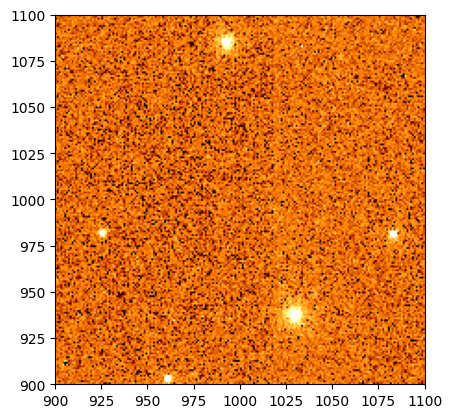

In [21]:
norm = simple_norm(dm.data, 'asinh', percent=99.7)
plt.imshow(dm.data[900:1100, 900:1100], norm=norm, cmap='afmhot', origin='lower',
           extent=[900, 1100, 900, 1100]);

Next, let's create our catalog. Let's choose a brightness of 2 x 10<sup>-8</sup> maggies (~19.25 AB magnitudes) for our source. Note that if you are injecting galaxies, then you will also need to supply the other parameters Roman I-Sim needs for galaxy sources (e.g., Sérsic index and half-light radius).

In the next cell, we make a function for creating and saving our injection catalog:

In [22]:
# Define a function to create the catalog for sources
# that we want to inject into our L2 image.

def make_cat(ra, dec, fluxes, filename='injection_cat.ecsv'):

    filtlist = 'F062 F087 F106 F129 F146 F158 F184 F213'.split()
    tab = Table([ra, dec], names = ('ra', 'dec'))
    src_types = np.array(['PSF' for i in ra])
    tab['type'] = src_types
    for k, v in fluxes.items():
        if k.upper() in filtlist:
            tab[k.upper()] = v
        else:
            raise ValueError(f'Incorrect filter name {k}!')

    tab.write(filename, overwrite=True)

And now run the function with our inputs:

In [23]:
# Get the RA and Dec from the WCS
ra, dec = dm.meta.wcs(1000, 1000)

# Make the injection catalog
make_cat([ra], [dec], {'F106': [2e-8]})

Let's take a look at the catalog we just created and make sure it looks correct:

In [24]:
tab = Table.read('injection_cat.ecsv')
tab

ra,dec,type,F106
float64,float64,str3,float64
270.904026679121,-0.19579469786176076,PSF,2e-08


Previously in this tutorial, we wrote a function to run Roman I-Sim. In that function, we overrode all of the default parameters and set them to `None` to force Roman I-Sim to use calibration reference files from CRDS rather than the Roman I-Sim default scalar values. These default scalar values are intended to allow Roman I-Sim to in an offline mode when you may not have access to a CRDS cache or the CRDS server. However, the current version of the `inject_sources_into_l2()` function does not use CRDS reference files and must use the Roman I-Sim defaults. Because the injection needs the default parameter values, we need to restore them here. We accomplish that using Python's `importlib.reload()` function to reload the installed version of `romanisim.parameters` into memory:

In [25]:
importlib.reload(parameters)

<module 'romanisim.parameters' from '/home/runner/micromamba/envs/ci-env/lib/python3.13/site-packages/romanisim/parameters.py'>

Now we run the source injection function `inject_sources_into_l2()` with our image (datamodel), the injection catalog (the variable `tab`), and we set `stpsf=True` to use STPSF-generated point spread functions (PSFs) for the simulation. Notice that we make a copy of the image using the `.copy()` method so that we inject the source into a copy of the image rather than the original. This lets us compare the original and the updated version after we inject the source.

As a reminder, this will use the default Roman I-Sim parameter values for the injected source; however, perhaps the most critical parameter (the gain) can be modified in the function call. The gain is important in the simulation as the WFI zeropoints in the L2 metadata are intended to transform from DN/s to MJy/sr, and therefore contain a factor of the gain. If needed, the gain value used in the zeropoint can be found in the photom reference file. In the cell below, we will set the gain to the default value (2 e<sup>–</sup>/DN) to demonstrate the proper way to modify the value.

In [26]:
result = inject_sources_into_l2(dm.copy(), tab, stpsf=True, gain=2 * (u.electron / u.DN))

2025-12-11 02:07:04 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:07:04 INFO     Using pupil mask 'F062' and detector 'WFI01'.


2025-12-11 02:07:04 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:07:05 INFO     No source spectrum supplied, therefore defaulting to 5700 K blackbody


2025-12-11 02:07:05 INFO     Computing wavelength weights using synthetic photometry for F106...


2025-12-11 02:07:05 INFO     Using pupil mask 'F106' and detector 'WFI01'.


2025-12-11 02:07:05 INFO     PSF calc using fov_arcsec = 5.000000, oversample = 4, number of wavelengths = 10


2025-12-11 02:07:05 INFO     Creating optical system model:


2025-12-11 02:07:05 INFO     Initialized OpticalSystem: Roman+WFI


2025-12-11 02:07:05 INFO     Roman Entrance Pupil: Loaded amplitude transmission from /home/runner/refdata/stpsf-data/WFI/pupils/RST_WIM_Filter_F106_WFI01.fits.gz


2025-12-11 02:07:05 INFO     Roman Entrance Pupil: Loaded OPD from /home/runner/refdata/stpsf-data/upscaled_HST_OPD.fits


2025-12-11 02:07:05 INFO     Added pupil plane: Roman Entrance Pupil


2025-12-11 02:07:05 INFO     Added coordinate inversion plane: OTE exit pupil


2025-12-11 02:07:05 INFO     Added pupil plane: Field Dependent Aberration (WFI01)


2025-12-11 02:07:05 INFO     Added detector with pixelscale=0.1078577405 and oversampling=4: WFI detector


2025-12-11 02:07:05 INFO     Calculating PSF with 10 wavelengths


2025-12-11 02:07:05 INFO      Propagating wavelength = 9.4555e-07 m


2025-12-11 02:07:06 INFO      Propagating wavelength = 9.7265e-07 m


2025-12-11 02:07:06 INFO      Propagating wavelength = 9.9975e-07 m


2025-12-11 02:07:07 INFO      Propagating wavelength = 1.02685e-06 m


2025-12-11 02:07:07 INFO      Propagating wavelength = 1.05395e-06 m


2025-12-11 02:07:08 INFO      Propagating wavelength = 1.08105e-06 m


2025-12-11 02:07:08 INFO      Propagating wavelength = 1.10815e-06 m


2025-12-11 02:07:09 INFO      Propagating wavelength = 1.13525e-06 m


2025-12-11 02:07:09 INFO      Propagating wavelength = 1.16235e-06 m


2025-12-11 02:07:10 INFO      Propagating wavelength = 1.18945e-06 m


2025-12-11 02:07:10 INFO       Calculation completed in 5.013 s


2025-12-11 02:07:10 INFO     PSF Calculation completed.


2025-12-11 02:07:10 INFO     Calculating jitter using gaussian


2025-12-11 02:07:10 INFO     Jitter: Convolving with Gaussian with sigma=0.012 arcsec


2025-12-11 02:07:10 INFO             resulting image peak drops to 0.946 of its previous value


2025-12-11 02:07:10 INFO     Detector charge diffusion not applied because charge_diffusion_sigma option is 0


2025-12-11 02:07:10 INFO      Adding extension with image downsampled to detector pixel scale.


2025-12-11 02:07:10 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:07:10 INFO      Downsampling to detector pixel scale, by 4


2025-12-11 02:07:10 INFO     Adding 1 sources to image...


2025-12-11 02:07:10 INFO     Rendered 1 sources...


2025-12-11 02:07:11 INFO     Fitting ramps.


Finally, let's re-plot the same region as before to show the injected source:

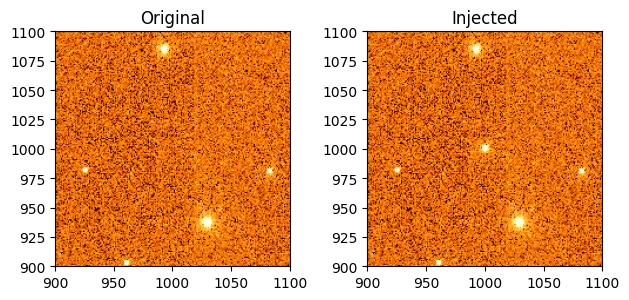

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].imshow(dm.data[900:1100, 900:1100], norm=norm, 
              cmap='afmhot', origin='lower',
              extent=[900, 1100, 900, 1100])

axs[0].set_title('Original')

axs[1].imshow(result.data[900:1100, 900:1100], norm=norm, 
              cmap='afmhot', origin='lower',
              extent=[900, 1100, 900, 1100])

axs[1].set_title('Injected')

plt.tight_layout();

## Additional Resources
- [Roman I-Sim Documentation](https://romanisim.readthedocs.io/en/latest/index.html)
- [RomanCal Documentation](https://roman-pipeline.readthedocs.io/en/latest/index.html)
- [Roman Documentation System (RDox)](https://roman-docs.stsci.edu)

***

## About this Notebook
**Author:** Sanjib Sharma, Tyler Desjardins  
**Updated On:** 2025-12-04

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>